In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
# Read data
listing=pd.read_csv("listing_us.csv")

/var/folders/wq/lz1mv8gj227bv83rhxpf97rh0000gn/T/ipykernel_69782/1542708656.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  listing=pd.read_csv("listing_us.csv")


## EDA

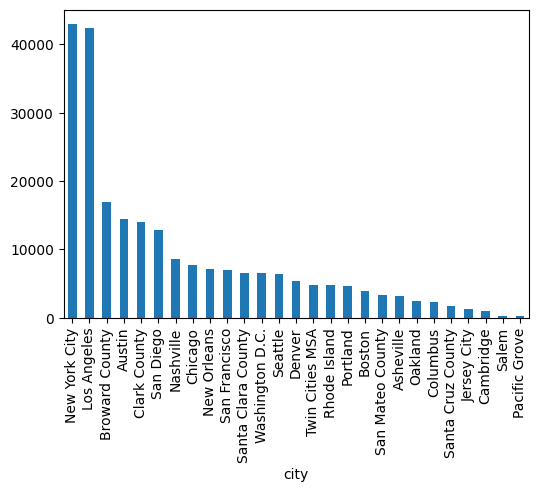

In [96]:
plt.figure(figsize=(6,4))
listing["city"].value_counts().plot(kind="bar")
plt.show()

In [97]:
listing.isnull().sum()

id                                     0
name                                  16
host_id                                0
host_name                             13
neighbourhood_group               135647
neighbourhood                          0
latitude                               0
longitude                              0
room_type                              0
price                                  0
minimum_nights                         0
number_of_reviews                      0
last_review                        49085
reviews_per_month                  49085
calculated_host_listings_count         0
availability_365                       0
number_of_reviews_ltm                  0
city                                   0
dtype: int64

Drop ["host_id", "host_name", "neighbourhood_group", "neighbourhood", "latitude", "longitude"]

In [98]:
listing["price"].describe()

count    232147.000000
mean        259.468001
std        1024.645918
min           0.000000
25%          91.000000
50%         149.000000
75%         250.000000
max      100000.000000
Name: price, dtype: float64

In [99]:
listing.drop(["host_id", "host_name", "neighbourhood_group", "neighbourhood", "latitude", "longitude"], axis=1, inplace=True)

In [100]:
from scipy import stats

In [101]:
# Remove Outlier
z_price = np.abs(stats.zscore(listing["price"]))
print(f"Percentage of data without outlier {round((len(listing[z_price<3])/len(listing)),4)*100}%")
listing = listing[z_price<3]

Percentage of data without outlier 99.63%


In [102]:
# EDA for last_review
from datetime import datetime
listing["last_review"] = pd.to_datetime(listing["last_review"])
listing["days_from_last_review_23"] = (datetime.strptime("2023-12-31", "%Y-%m-%d") - listing["last_review"]).dt.days
listing["days_from_last_review_23"].fillna(-1, inplace=True)
listing["days_from_last_review_23"]=listing["days_from_last_review_23"].astype(int)

/var/folders/wq/lz1mv8gj227bv83rhxpf97rh0000gn/T/ipykernel_69782/1869866303.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  listing["days_from_last_review_23"].fillna(-1, inplace=True)


In [103]:
-listing[((listing["city"]=="Los Angeles")|(listing["city"]=="New York City"))&(listing["days_from_last_review_23"]==-1)]["days_from_last_review_23"].sum()/len(listing)

np.float64(0.09388228070858141)

In [104]:
# Make rating cuz no. of reviews are scattered  
listing["reviews_rate"] = listing["number_of_reviews_ltm"]/listing["number_of_reviews"]

In [105]:
# Binning 'availability_365' into 4 bins
listing['availability'] = pd.cut(listing['availability_365'], bins=[0, 90, 180, 270, 365], labels=['low', 'medium', 'high', 'very high'])

In [106]:
# Price itself itn't a good feature, 
listing['price_per_night'] = listing['price'] / listing['minimum_nights']

In [107]:
listing.drop(["id", "name"], axis=1, inplace=True)

In [108]:
from sklearn.preprocessing import StandardScaler

numeric_columns = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
                   'calculated_host_listings_count', "availability_365",
                   'number_of_reviews_ltm', 'days_from_last_review_23']

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the standardization to the selected numeric columns
listing[numeric_columns] = scaler.fit_transform(listing[numeric_columns])

<Axes: >

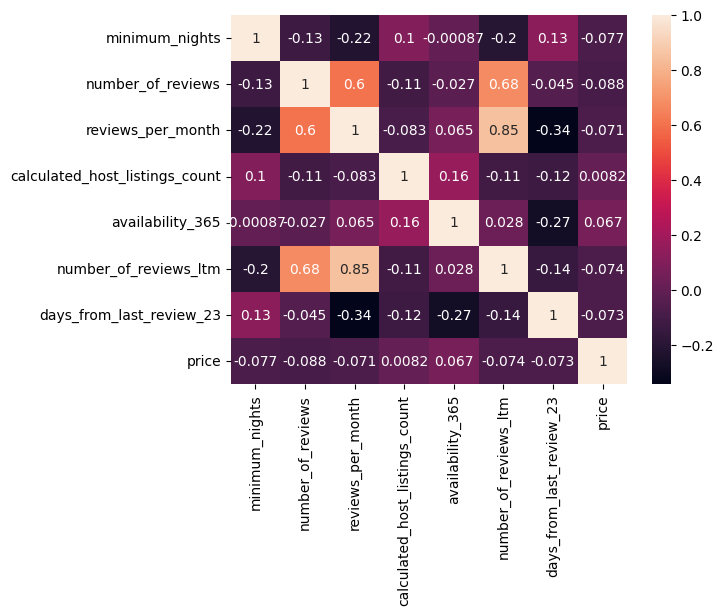

In [109]:
numeric_columns.append("price")
sns.heatmap(listing[numeric_columns].corr(), annot=True)

(0.0, 700.0)

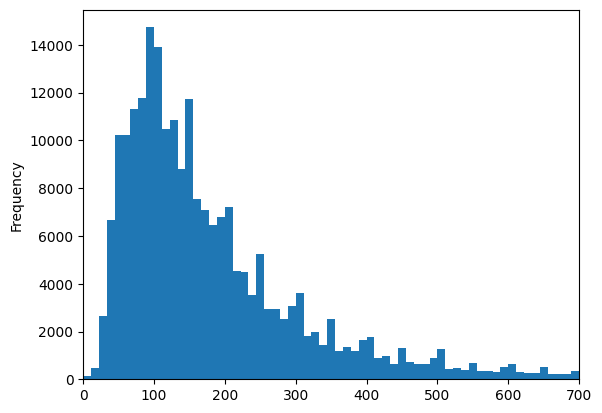

In [110]:
listing["price"].plot(kind="hist", bins=300)
plt.xlim(0,700)

In [111]:
listing["price"].describe()

count    231279.00000
mean        222.83302
std         268.74149
min           0.00000
25%          90.00000
50%         149.00000
75%         250.00000
max        3333.00000
Name: price, dtype: float64

In [112]:
#Create Category outcome by price threshold. I feel 50 bucks per night is good threshold. Over 50, i feel expensive.
def categorize_price(price):
    if price < 120:
        return 'low'
    else:
        return 'high'

In [113]:
listing['price_category'] = listing['price'].apply(categorize_price)

In [114]:
listing["price_category"].value_counts()/len(listing)

price_category
high    0.616835
low     0.383165
Name: count, dtype: float64

In [115]:
# create dummy variables for room type
dummies = pd.get_dummies(listing["room_type"], prefix="roomtype")
listing = pd.concat([listing, dummies], axis=1)


In [116]:
listing["price_category"].replace({"high":1, "low":0}, inplace=True)

/var/folders/wq/lz1mv8gj227bv83rhxpf97rh0000gn/T/ipykernel_69782/3717071175.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  listing["price_category"].replace({"high":1, "low":0}, inplace=True)
/var/folders/wq/lz1mv8gj227bv83rhxpf97rh0000gn/T/ipykernel_69782/3717071175.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silen

## Model

In [117]:
"""
X; roomtype_Entire home/apt, roomtype_Hotel room, roomtype_Private room, number_of_reviews_ltm, availability_365, days_from_last_review_23, (calculated_host_listings_count)
y; price_category
"""

'\nX; roomtype_Entire home/apt, roomtype_Hotel room, roomtype_Private room, number_of_reviews_ltm, availability_365, days_from_last_review_23, (calculated_host_listings_count)\ny; price_category\n'

In [118]:
# Filter for city
listing_la = listing[listing["city"]=="Los Angeles"]
listing_ny = listing[listing["city"]=="New York City"]

In [119]:
x_columns = ["roomtype_Entire home/apt", "roomtype_Hotel room", "roomtype_Private room", "number_of_reviews_ltm", "availability_365", "days_from_last_review_23", "calculated_host_listings_count", "minimum_nights"]

In [120]:
X_la = listing_la[x_columns].astype(int)
y_la = listing_la["price_category"]
X_ny = listing_ny[x_columns].astype(int)
y_ny = listing_ny["price_category"]

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [122]:
# Split data
X_la_train, X_la_test, y_la_train, y_la_test = train_test_split(X_la, y_la, test_size=0.3, random_state=42)
X_ny_train, X_ny_test, y_ny_train, y_ny_test = train_test_split(X_ny, y_ny, test_size=0.3, random_state=42)

In [123]:
from imblearn.over_sampling import SMOTE

In [124]:
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_la_train_smote, y_la_train_smote = smote.fit_resample(X_la_train, y_la_train)
X_ny_train_smote, y_ny_train_smote = smote.fit_resample(X_ny_train, y_ny_train)

In [125]:
listing.columns

Index(['room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'city',
       'days_from_last_review_23', 'reviews_rate', 'availability',
       'price_per_night', 'price_category', 'roomtype_Entire home/apt',
       'roomtype_Hotel room', 'roomtype_Private room', 'roomtype_Shared room'],
      dtype='object')

In [126]:
listing[(listing["city"]=="Los Angeles")|(listing["city"]=="New York City")].groupby(["city", "room_type"])["price"].agg(["mean", "std"])

mean         std
city          room_type                              
Los Angeles   Entire home/apt  286.623952  346.908029
              Hotel room       159.607595  145.461019
              Private room     105.538278  151.863186
              Shared room       72.962644  141.504430
New York City Entire home/apt  233.765507  234.172302
              Hotel room       309.959391  284.291418
              Private room     111.031038  165.630697
              Shared room      100.557491  188.945506

### Logistic Regression

In [127]:
from sklearn.linear_model import LogisticRegression

In [128]:
lr_la = LogisticRegression(penalty="l2",C=0.001)
lr_la.fit(X_la_train_smote, y_la_train_smote)
lr_ny = LogisticRegression()
lr_ny.fit(X_ny_train_smote, y_ny_train_smote)

LogisticRegression()

In [129]:
y_pred_la = lr_la.predict(X_la_test)
#y_pred_
y_pred_ny = lr_ny.predict(X_ny_test)

In [130]:
# model validation

accuracy_la = accuracy_score(y_la_test, y_pred_la)
conf_matrix_la = confusion_matrix(y_la_test, y_pred_la)
report_la = classification_report(y_la_test, y_pred_la)

print("Accuracy, Los Angeles:", accuracy_la)
print("\nConfusion Matrix, Los Angeles:\n", conf_matrix_la)
print("\nClassification Report, Los Angeles:\n", report_la)

Accuracy, Los Angeles: 0.7883748517200474

Confusion Matrix, Los Angeles:
 [[3299 1905]
 [ 771 6670]]

Classification Report, Los Angeles:
               precision    recall  f1-score   support

           0       0.81      0.63      0.71      5204
           1       0.78      0.90      0.83      7441

    accuracy                           0.79     12645
   macro avg       0.79      0.77      0.77     12645
weighted avg       0.79      0.79      0.78     12645



#### Summary of Logistic Regression result, LA
- Label "low", 0, price < $150 by each night
 Precision: 0.85, the ratio of correctly predicted instances of "low" out of all instances predicted "low". 85% of the prediction of "low" were correct in all prediction. Soso nice
 Recall: 0.56, the ratio of correctly predicted instances of "low" out of all instances actual "low" 56% of the prediction of "low" were correct in all actual. Absolutely nice.
 F1 score: 0.68, Overall evaluation with consideration of precision and recall. aroun 70% is good.

- Label "high", 1, price >= $150 by each night
 Precision: 0.65, the ratio of correctly predicted instances of "high" out of all instances predicted "high". 65% of the prediction of "low" were correct in all prediction. Pretty good
 Recall: 0.90, the ratio of correctly predicted instances of "high" out of all instances actual "high". 90% of the prediction of "low" were correct in all actual. So bad, assume this affect the overall accuracy.
 F1 score: 0.76, Overall evaluation with consideration of precision and recall. 76% is pretty good.

=> Prediction for label 0 is bit low....

In [131]:
# obtain coefficients
coefficients_la = lr_la.coef_[0]  # yが2クラスの場合
feature_names_la = X_la_train_smote.columns

# Aggregate coefficients into a dataframe
coeff_df_la = pd.DataFrame({
    'Feature': feature_names_la,
    'Coefficient': coefficients_la
})

# sort by importances
coeff_df_la = coeff_df_la.sort_values(by='Coefficient', ascending=False)
print(coeff_df_la)

                          Feature  Coefficient
0        roomtype_Entire home/apt     1.085091
4                availability_365     0.156866
3           number_of_reviews_ltm     0.028664
7                  minimum_nights     0.009736
1             roomtype_Hotel room     0.009102
6  calculated_host_listings_count    -0.052583
5        days_from_last_review_23    -0.179746
2           roomtype_Private room    -0.870634


In [132]:
# Intercept
print(lr_la.intercept_[0])

-0.40622228517597864


In [133]:
import statsmodels.api as sm

In [134]:
# statsmodelsは切片を明示的に含める必要がある
X = sm.add_constant(X_la_train_smote)

# ロジスティック回帰モデルのフィッティング
model = sm.Logit(y_la_train_smote, X)
result = model.fit()

# サマリを表示
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.520548
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         price_category   No. Observations:                34966
Model:                          Logit   Df Residuals:                    34957
Method:                           MLE   Df Model:                            8
Date:                Sat, 30 Nov 2024   Pseudo R-squ.:                  0.2490
Time:                        20:14:36   Log-Likelihood:                -18201.
converged:                       True   LL-Null:                       -24237.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -2.6740      0.158    -16.919     

In [135]:
# model validation
accuracy_ny = accuracy_score(y_ny_test, y_pred_ny)
conf_matrix_ny = confusion_matrix(y_ny_test, y_pred_ny)
report_ny = classification_report(y_ny_test, y_pred_ny)

print("Accuracy, New York:", accuracy_ny)
print("\nConfusion Matrix, New York:\n", conf_matrix_ny)
print("\nClassification Report, New York:\n", report_ny)

Accuracy, New York: 0.784769757311761

Confusion Matrix, New York:
 [[4364 1655]
 [1112 5725]]

Classification Report, New York:
               precision    recall  f1-score   support

           0       0.80      0.73      0.76      6019
           1       0.78      0.84      0.81      6837

    accuracy                           0.78     12856
   macro avg       0.79      0.78      0.78     12856
weighted avg       0.79      0.78      0.78     12856



#### Summary of Logistic Regression result, NY
- Label "low", 0, price < $50 by each night
 Precision: 0.72, the ratio of correctly predicted instances of "low" out of all instances predicted "low". 72% of the prediction of "low" were correct in all prediction. Soso nice
 Recall: 0.91, the ratio of correctly predicted instances of "low" out of all instances actual "low" 91% of the prediction of "low" were correct in all actual. Absolutely nice.
 F1 score: 0.80, Overall evaluation with consideration of precision and recall. aroun 0.80 is pretty good.

- Label "high", 0, price >= $50 by each night
 Precision: 0.63, the ratio of correctly predicted instances of "high" out of all instances predicted "high". 63% of the prediction of "low" were correct in all prediction. Pretty good
 Recall: 0.31, the ratio of correctly predicted instances of "high" out of all instances actual "high". 31% of the prediction of "low" were correct in all actual. So bad, assume this affect the overall accuracy.
 F1 score: 0.42, Overall evaluation with consideration of precision and recall. 0,42 is pretty bad.

=> Prediction for label 1 is low as well.... Seems model for New York is more balanced compared to LA.

In [136]:
# obtain coefficients
coefficients_ny = lr_ny.coef_[0]  # yが2クラスの場合
feature_names_ny = X_ny_train.columns

# Aggregate coefficients into a dataframe
coeff_df_ny = pd.DataFrame({
    'Feature': feature_names_ny,
    'Coefficient': coefficients_ny
})

# sort by importances
coeff_df_ny = coeff_df_ny.sort_values(by='Coefficient', ascending=False)
print(coeff_df_ny)

                          Feature  Coefficient
1             roomtype_Hotel room     2.814420
0        roomtype_Entire home/apt     2.705744
6  calculated_host_listings_count     0.219892
4                availability_365     0.138346
2           roomtype_Private room     0.098957
3           number_of_reviews_ltm    -0.034910
7                  minimum_nights    -0.073143
5        days_from_last_review_23    -0.136152


In [137]:
# Intercept
print(lr_ny.intercept_[0])

-1.4886807340512143


In [138]:
# statsmodelsは切片を明示的に含める必要がある
X_ny = sm.add_constant(X_ny_train_smote)

# ロジスティック回帰モデルのフィッティング
model_ny = sm.Logit(y_ny_train_smote, X_ny)
result_ny = model_ny.fit()

# サマリを表示
print(result_ny.summary())

Optimization terminated successfully.
         Current function value: 0.517813
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         price_category   No. Observations:                31908
Model:                          Logit   Df Residuals:                    31899
Method:                           MLE   Df Model:                            8
Date:                Sat, 30 Nov 2024   Pseudo R-squ.:                  0.2530
Time:                        20:14:36   Log-Likelihood:                -16522.
converged:                       True   LL-Null:                       -22117.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -1.5877      0.130    -12.208     

No difference, let's search another model, and redo feature engineering

## Decision Tree

In [139]:
from sklearn.tree import DecisionTreeClassifier

In [140]:
dt = DecisionTreeClassifier(criterion="entropy", random_state=42)
dt_la = dt.fit(X_la_train, y_la_train)
y_pred_dt_la = dt_la.predict(X_la_test)
dt_ny = dt.fit(X_ny_train, y_ny_train)
y_pred_dt_ny = dt_ny.predict(X_ny_test)

In [141]:
# model validation
accuracy_la_dt = accuracy_score(y_la_test, y_pred_dt_la)
conf_matrix_la_dt = confusion_matrix(y_la_test, y_pred_dt_la)
report_la_dt = classification_report(y_la_test, y_pred_dt_la)

print("Accuracy, Los Angeles:", accuracy_la_dt)
print("\nConfusion Matrix, Los Angeles:\n", conf_matrix_la_dt)
print("\nClassification Report, Los Angeles:\n", report_la_dt)

Accuracy, Los Angeles: 0.789640173981811

Confusion Matrix, Los Angeles:
 [[3297 1907]
 [ 753 6688]]

Classification Report, Los Angeles:
               precision    recall  f1-score   support

           0       0.81      0.63      0.71      5204
           1       0.78      0.90      0.83      7441

    accuracy                           0.79     12645
   macro avg       0.80      0.77      0.77     12645
weighted avg       0.79      0.79      0.78     12645



In [142]:
feature_importances_la_dt = dt_la.feature_importances_

# Aggegate Feature & Importances into data frame
importance_df_la_dt = pd.DataFrame({
    'Feature': X_la_train.columns,
    'Importance': feature_importances_la_dt
})

# Sort by imortances
importance_df_la_dt = importance_df_la_dt.sort_values(by='Importance', ascending=False)
print(importance_df_la_dt)

                          Feature  Importance
0        roomtype_Entire home/apt    0.842714
6  calculated_host_listings_count    0.045204
4                availability_365    0.027429
5        days_from_last_review_23    0.027405
7                  minimum_nights    0.022270
1             roomtype_Hotel room    0.020628
3           number_of_reviews_ltm    0.011900
2           roomtype_Private room    0.002450


In [143]:
# model validation
accuracy_ny_dt = accuracy_score(y_ny_test, y_pred_dt_ny)
conf_matrix_ny_dt = confusion_matrix(y_ny_test, y_pred_dt_ny)
report_ny_dt = classification_report(y_ny_test, y_pred_dt_ny)

print("Accuracy, New York:", accuracy_ny_dt)
print("\nConfusion Matrix, New York:\n", conf_matrix_ny_dt)
print("\nClassification Report, New York:\n", report_ny_dt)

Accuracy, New York: 0.7840696950840075

Confusion Matrix, New York:
 [[4373 1646]
 [1130 5707]]

Classification Report, New York:
               precision    recall  f1-score   support

           0       0.79      0.73      0.76      6019
           1       0.78      0.83      0.80      6837

    accuracy                           0.78     12856
   macro avg       0.79      0.78      0.78     12856
weighted avg       0.78      0.78      0.78     12856



In [144]:
feature_importances_ny_dt = dt_ny.feature_importances_

# Aggegate Feature & Importances into data frame
importance_df_ny_dt = pd.DataFrame({
    'Feature': X_ny_train.columns,
    'Importance': feature_importances_ny_dt
})

# Sort by imortances
importance_df_ny_dt = importance_df_ny_dt.sort_values(by='Importance', ascending=False)
print(importance_df_ny_dt)

                          Feature  Importance
0        roomtype_Entire home/apt    0.842714
6  calculated_host_listings_count    0.045204
4                availability_365    0.027429
5        days_from_last_review_23    0.027405
7                  minimum_nights    0.022270
1             roomtype_Hotel room    0.020628
3           number_of_reviews_ltm    0.011900
2           roomtype_Private room    0.002450


No huge difference between Logistic Regression and Decision Tree, meaning that model does not matter, featuer engineering. we wanna know which attributes is affecting most. For New York, Decision Tree is bit better than Logistic Regression.

=> For Los Angeles, Overfitting????

## Ensemble Learning, RandomForest

In [145]:
from sklearn.ensemble import RandomForestClassifier

In [146]:
# Random Forest Model
rf = RandomForestClassifier(criterion="entropy", n_estimators=100, random_state=42)

# training
#rf_la=rf.fit(X_la_train_smote, y_la_train_smote)
rf_la=rf.fit(X_la_train, y_la_train)

# Prediction
y_pred_rf_la = rf_la.predict(X_la_test)

# accuracy check
accuracy_rf_la = accuracy_score(y_la_test, y_pred_rf_la)
print(f"Accuracy of Random Forest model: {accuracy_rf_la:.4f}")
print(f"Original Model Accuracy: {accuracy_la_dt:.4f}")

Accuracy of Random Forest model: 0.7896
Original Model Accuracy: 0.7896


In [147]:
# model validation
accuracy_la_rf = accuracy_score(y_la_test, y_pred_rf_la)
conf_matrix_la_rf = confusion_matrix(y_la_test, y_pred_rf_la)
report_la_rf = classification_report(y_la_test, y_pred_rf_la)

print("Accuracy, LA:", accuracy_la_rf)
print("\nConfusion Matrix, LA:\n", conf_matrix_la_rf)
print("\nClassification Report, LA:\n", report_la_rf)

Accuracy, LA: 0.789640173981811

Confusion Matrix, LA:
 [[3290 1914]
 [ 746 6695]]

Classification Report, LA:
               precision    recall  f1-score   support

           0       0.82      0.63      0.71      5204
           1       0.78      0.90      0.83      7441

    accuracy                           0.79     12645
   macro avg       0.80      0.77      0.77     12645
weighted avg       0.79      0.79      0.78     12645



In [148]:
feature_importances_la = rf_la.feature_importances_

# Aggegate Feature & Importances into data frame
importance_df_la = pd.DataFrame({
    'Feature': X_la_train.columns,
    'Importance': feature_importances_la
})

# Sort by imortances
importance_df_la = importance_df_la.sort_values(by='Importance', ascending=False)
print(importance_df_la)

                          Feature  Importance
0        roomtype_Entire home/apt    0.451439
2           roomtype_Private room    0.395583
6  calculated_host_listings_count    0.048236
5        days_from_last_review_23    0.039095
4                availability_365    0.033769
7                  minimum_nights    0.015587
3           number_of_reviews_ltm    0.009482
1             roomtype_Hotel room    0.006809


In [149]:
# Random Forest Model
rf = RandomForestClassifier(criterion="entropy", n_estimators=100, random_state=42)

# 学習
rf_ny=rf.fit(X_ny_train, y_ny_train)

# 予測
y_pred_rf_ny = rf_ny.predict(X_ny_test)

# 精度評価
accuracy_rf_ny = accuracy_score(y_ny_test, y_pred_rf_ny)
print(f"Accuracy of Random Forest model: {accuracy_rf_ny:.4f}")
print(f"Original Model Accuracy: {accuracy_ny_dt:.4f}")

Accuracy of Random Forest model: 0.7844
Original Model Accuracy: 0.7841


In [180]:
# model validation
accuracy_ny_rf = accuracy_score(y_ny_test, y_pred_rf_ny)
conf_matrix_ny_rf = confusion_matrix(y_ny_test, y_pred_rf_ny)
report_ny_rf = classification_report(y_ny_test, y_pred_rf_ny)

print("Accuracy, NY:", accuracy_ny_rf)
print("\nConfusion Matrix, NY:\n", conf_matrix_ny_rf)
print("\nClassification Report, NY:\n", report_ny_rf)

Accuracy, NY: 0.7843808338518979

Confusion Matrix, NY:
 [[4369 1650]
 [1122 5715]]

Classification Report, NY:
               precision    recall  f1-score   support

           0       0.80      0.73      0.76      6019
           1       0.78      0.84      0.80      6837

    accuracy                           0.78     12856
   macro avg       0.79      0.78      0.78     12856
weighted avg       0.79      0.78      0.78     12856



In [151]:
feature_importances_ny = rf_ny.feature_importances_

# Aggegate Feature & Importances into data frame
importance_df_ny = pd.DataFrame({
    'Feature': X_ny_train.columns,
    'Importance': feature_importances_ny
})

# Sort by imortances
importance_df_ny = importance_df_ny.sort_values(by='Importance', ascending=False)
print(importance_df_ny)

                          Feature  Importance
0        roomtype_Entire home/apt    0.422637
2           roomtype_Private room    0.412098
6  calculated_host_listings_count    0.049296
5        days_from_last_review_23    0.036509
7                  minimum_nights    0.025080
4                availability_365    0.024629
1             roomtype_Hotel room    0.015278
3           number_of_reviews_ltm    0.014473


## GridSearch for Logistic Regression, Optional

In [152]:
from sklearn.model_selection import GridSearchCV

In [153]:
param_grid = {"penalty": ['l2', 'l1', "elasticnet", None], "C":[0.001, 0.0001]}

In [154]:
# Grid search with cross validation
grid_search_la = GridSearchCV(LogisticRegression(), param_grid, cv=10, n_jobs=-1)
grid_search_la.fit(X_la_train_smote, y_la_train_smote)

# Show the best parameter and score
print("Best Parameters for Logistic Regression (LA):", grid_search_la.best_params_)
print("Best Score for Logistic Regression (LA):", grid_search_la.best_score_)

# predict with the best model
y_pred_la_grid = grid_search_la.best_estimator_.predict(X_la_test)

/Users/moritakento/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/moritakento/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/moritakento/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/moritakento/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/moritakento/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/moritakento/L

Best Parameters for Logistic Regression (LA): {'C': 0.001, 'penalty': 'l2'}
Best Score for Logistic Regression (LA): 0.7662876205102904


In [155]:
# model validation
accuracy_la_grid = accuracy_score(y_la_test, y_pred_la_grid)
conf_matrix_la_grid = confusion_matrix(y_la_test, y_pred_la_grid)
report_la_grid = classification_report(y_la_test, y_pred_la_grid)

print("Accuracy, Los Angeles:", accuracy_la_grid)
print("\nConfusion Matrix, Los Angeles:\n", conf_matrix_la_grid)
print("\nClassification Report, Los Angeles:\n", report_la_grid)
print(f"Original normal score is {accuracy_la}")

Accuracy, Los Angeles: 0.7883748517200474

Confusion Matrix, Los Angeles:
 [[3299 1905]
 [ 771 6670]]

Classification Report, Los Angeles:
               precision    recall  f1-score   support

           0       0.81      0.63      0.71      5204
           1       0.78      0.90      0.83      7441

    accuracy                           0.79     12645
   macro avg       0.79      0.77      0.77     12645
weighted avg       0.79      0.79      0.78     12645

Original normal score is 0.7883748517200474


In [156]:
# Overfitting Check
cv_mean_accuracy_grid_la_lr = grid_search_la.best_score_
print(f"CV Mean Accuracy: {cv_mean_accuracy_grid_la_lr:.4f}")
print(f"Test Set Accuracy: {accuracy_la_grid:.4f}")

CV Mean Accuracy: 0.7663
Test Set Accuracy: 0.7884


In [157]:
# Get the best model from GridSearch
best_model_lr_la = grid_search_la.best_estimator_

# Get attributes' coefficients
coefficients_lr_la = best_model_lr_la.coef_[0]  # Coefficients in logistic regression
intercept_lr_la = best_model_lr_la.intercept_   # interception

# Align attributes' name with coefficients
feature_names_la = X_la_train.columns  # attributes name
coeff_df_lr_la = pd.DataFrame({"Feature": feature_names_la, "Coefficient": coefficients_lr_la})

# Sort by coefficients
coeff_df_lr_la = coeff_df_lr_la.sort_values(by="Coefficient", ascending=False)

# Display results
print(coeff_df_lr_la)

                          Feature  Coefficient
0        roomtype_Entire home/apt     1.085091
4                availability_365     0.156866
3           number_of_reviews_ltm     0.028664
7                  minimum_nights     0.009736
1             roomtype_Hotel room     0.009102
6  calculated_host_listings_count    -0.052583
5        days_from_last_review_23    -0.179746
2           roomtype_Private room    -0.870634


In [158]:
# Grid search with cross validation
grid_search_ny = GridSearchCV(LogisticRegression(), param_grid, cv=10, n_jobs=-1)
grid_search_ny.fit(X_ny_train_smote, y_ny_train_smote)

# Show the best parameter and score
print("Best Parameters for Logistic Regression (NY):", grid_search_ny.best_params_)
print("Best Score for Logistic Regression (NY):", grid_search_ny.best_score_)

# predict with the best model
y_pred_ny_grid = grid_search_ny.best_estimator_.predict(X_ny_test)

/Users/moritakento/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/moritakento/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/moritakento/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/moritakento/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/moritakento/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/moritakento/L

Best Parameters for Logistic Regression (NY): {'C': 0.001, 'penalty': None}
Best Score for Logistic Regression (NY): 0.7806191590965579


/Users/moritakento/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/moritakento/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/moritakento/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/moritakento/Library/Python/3.9/lib/python/site-packages/skl

In [159]:
# model validation
accuracy_ny_grid = accuracy_score(y_ny_test, y_pred_ny_grid)
conf_matrix_ny_grid = confusion_matrix(y_ny_test, y_pred_ny_grid)
report_ny_grid = classification_report(y_ny_test, y_pred_ny_grid)

print("Accuracy, New York:", accuracy_ny_grid)
print("\nConfusion Matrix, New York:\n", conf_matrix_ny_grid)
print("\nClassification Report, New York:\n", report_ny_grid)
print(f"Original Accuracy is {accuracy_ny}")

Accuracy, New York: 0.784769757311761

Confusion Matrix, New York:
 [[4364 1655]
 [1112 5725]]

Classification Report, New York:
               precision    recall  f1-score   support

           0       0.80      0.73      0.76      6019
           1       0.78      0.84      0.81      6837

    accuracy                           0.78     12856
   macro avg       0.79      0.78      0.78     12856
weighted avg       0.79      0.78      0.78     12856

Original Accuracy is 0.784769757311761


In [160]:
# Overfitting Check
cv_mean_accuracy_grid_ny_lr = grid_search_ny.best_score_
print(f"CV Mean Accuracy: {cv_mean_accuracy_grid_ny_lr:.4f}")
print(f"Test Set Accuracy: {accuracy_ny_grid:.4f}")

CV Mean Accuracy: 0.7806
Test Set Accuracy: 0.7848


In [161]:
# Get the best model from GridSearch
best_model_lr_ny = grid_search_ny.best_estimator_

# Get attributes' coefficients
coefficients_lr_ny = best_model_lr_ny.coef_[0]  # Coefficients in logistic regression
intercept_lr_ny = best_model_lr_ny.intercept_   # interception

# Align attributes' name with coefficients
feature_names_ny = X_ny_train.columns  # attributes name
coeff_df_lr_ny = pd.DataFrame({"Feature": feature_names_ny, "Coefficient": coefficients_lr_ny})

# Sort by coefficients
coeff_df_lr_ny = coeff_df_lr_ny.sort_values(by="Coefficient", ascending=False)

# Display results
print(coeff_df_lr_ny)

                          Feature  Coefficient
1             roomtype_Hotel room     3.037147
0        roomtype_Entire home/apt     2.804203
6  calculated_host_listings_count     0.218946
2           roomtype_Private room     0.197292
4                availability_365     0.139009
3           number_of_reviews_ltm    -0.035323
7                  minimum_nights    -0.073572
5        days_from_last_review_23    -0.135911


No difference, let's search another model, and redo feature engineering

## Grid Searc for Decision Tree, Optional

In [162]:
# parameters
param_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

In [163]:
# Optimization of parameters
grid_search_la_dt = GridSearchCV(DecisionTreeClassifier(criterion = "entropy",random_state=42), param_grid_dt, cv=10, n_jobs=-1)
grid_search_la_dt.fit(X_la_train, y_la_train)

# Display best parameters
print("Best parameters found by GridSearchCV:", grid_search_la_dt.best_params_)

# Predict with best model
y_pred_dt_optimized_la = grid_search_la_dt.best_estimator_.predict(X_la_test)

# 精度評価
accuracy_optimized_la_dt = accuracy_score(y_la_test, y_pred_dt_optimized_la)
print(f"Optimized Decision Tree Accuracy: {accuracy_optimized_la_dt:.4f}")
print(f"Original Model Accuracy: {accuracy_la_dt:.4f}")

Best parameters found by GridSearchCV: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2}
Optimized Decision Tree Accuracy: 0.7898
Original Model Accuracy: 0.7896


In [164]:
# Overfitting Check
cv_mean_accuracy_grid_la_dt = grid_search_la_dt.best_score_
print(f"CV Mean Accuracy: {cv_mean_accuracy_grid_la_dt:.4f}")
print(f"Test Set Accuracy: {accuracy_la_dt:.4f}")

CV Mean Accuracy: 0.7925
Test Set Accuracy: 0.7896


In [165]:
# Get the best model from GridSearch
best_model_dt_la = grid_search_la_dt.best_estimator_

# Get attributes' coefficients
coefficients_dt_la = best_model_dt_la.feature_importances_

# Align attributes' name with coefficients
feature_names_la = X_la_train.columns  # attributes name
coeff_df_dt_la = pd.DataFrame({"Feature": feature_names_la, "Coefficient": coefficients_dt_la})

# Sort by coefficients
coeff_df_dt_la = coeff_df_dt_la.sort_values(by="Coefficient", ascending=False)

# Display results
print(coeff_df_dt_la)

                          Feature  Coefficient
0        roomtype_Entire home/apt     0.888945
6  calculated_host_listings_count     0.031900
5        days_from_last_review_23     0.029199
4                availability_365     0.028751
7                  minimum_nights     0.007283
1             roomtype_Hotel room     0.006593
3           number_of_reviews_ltm     0.006484
2           roomtype_Private room     0.000845


In [166]:
# Optimization of parameters
grid_search_ny_dt = GridSearchCV(DecisionTreeClassifier(criterion = "entropy",random_state=42), param_grid_dt, cv=10, n_jobs=-1)
grid_search_ny_dt.fit(X_ny_train, y_ny_train)

# Display best parameters
print("Best parameters found by GridSearchCV:", grid_search_ny_dt.best_params_)

# Predict with best model
y_pred_dt_optimized_ny= grid_search_la_dt.best_estimator_.predict(X_ny_test)

# Accuracy validation
accuracy_optimized_ny_dt = accuracy_score(y_ny_test, y_pred_dt_optimized_ny)
print(f"Optimized Decision Tree Accuracy: {accuracy_optimized_ny_dt:.4f}")
print(f"Original Model Accuracy: {accuracy_ny_dt:.4f}")

Best parameters found by GridSearchCV: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Optimized Decision Tree Accuracy: 0.7645
Original Model Accuracy: 0.7841


In [167]:
# Overfitting Check
cv_mean_accuracy_grid_ny_dt = grid_search_ny_dt.best_score_
print(f"CV Mean Accuracy: {cv_mean_accuracy_grid_ny_dt:.4f}")
print(f"Test Set Accuracy: {accuracy_ny_dt:.4f}")

CV Mean Accuracy: 0.7846
Test Set Accuracy: 0.7841


In [168]:
# Get the best model from GridSearch
best_model_dt_ny = grid_search_ny_dt.best_estimator_

# Get attributes' coefficients
coefficients_dt_ny = best_model_dt_ny.feature_importances_

# Align attributes' name with coefficients
feature_names_ny = X_la_train.columns  # attributes name
coeff_df_dt_ny = pd.DataFrame({"Feature": feature_names_ny, "Coefficient": coefficients_dt_ny})

# Sort by coefficients
coeff_df_dt_ny = coeff_df_dt_ny.sort_values(by="Coefficient", ascending=False)

# Display results
print(coeff_df_dt_ny)

                          Feature  Coefficient
0        roomtype_Entire home/apt     0.852635
6  calculated_host_listings_count     0.045363
4                availability_365     0.026993
5        days_from_last_review_23     0.025671
1             roomtype_Hotel room     0.020871
7                  minimum_nights     0.016258
3           number_of_reviews_ltm     0.010498
2           roomtype_Private room     0.001710


## Feature Selection, Optional

In [169]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [170]:
X_la_train.shape

(29503, 8)

In [171]:
sfs_model_la=sfs(RandomForestClassifier(criterion="entropy"),k_features = 8,
                forward=True,
                verbose=2,
                cv=5,
                n_jobs=-1,
                scoring='r2')
sfs_model_la.fit(X_la_train, y_la_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    2.6s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.7s finished

[2024-11-30 20:14:58] Features: 1/8 -- score: 0.1326527690047799[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    2.7s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    2.8s finished

[2024-11-30 20:15:01] Features: 2/8 -- score: 0.13447787600676694[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.7s finished

[2024-11-30 20:15:04] Features: 3/8 -- score: 0.136302983008754[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | 

SequentialFeatureSelector(estimator=RandomForestClassifier(criterion='entropy'),
                          k_features=(8, 8), n_jobs=-1, scoring='r2',
                          verbose=2)

In [172]:
print('Best accuracy score: %.2f' % sfs_model_la.k_score_)   # k_score_ shows the best score 
print('Best subset (indices):', sfs_model_la.k_feature_idx_) # k_feature_idx_ shows the index of features that yield the best score

Best accuracy score: 0.14
Best subset (indices): (0, 1, 2, 3, 4, 5, 6, 7)


In [173]:
print('Best subset (corresponding names):')
sfs_model_la.k_feature_names_

Best subset (corresponding names):


('roomtype_Entire home/apt',
 'roomtype_Hotel room',
 'roomtype_Private room',
 'number_of_reviews_ltm',
 'availability_365',
 'days_from_last_review_23',
 'calculated_host_listings_count',
 'minimum_nights')

In [174]:
listing

,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,city,days_from_last_review_23,reviews_rate,availability,price_per_night,price_category,roomtype_Entire home/apt,roomtype_Hotel room,roomtype_Private room,roomtype_Shared room
0,Entire home/apt,202,-0.412692,4.235850,2023-02-19,0.350467,-0.271630,-0.392730,2.291858,San Francisco,-0.257208,0.154047,medium,101.000000,1,True,False,False,False
1,Entire home/apt,235,0.592791,0.866732,2017-08-06,-0.512707,-0.271630,1.367066,-0.568612,San Francisco,3.452959,0.000000,very high,7.833333,1,True,False,False,False
2,Private room,56,0.664612,-0.396688,2022-10-27,-0.810894,-0.158442,1.367066,-0.520129,San Francisco,-0.046298,0.111111,very high,1.750000,0,False,False,True,False
3,Entire home/apt,575,-0.161321,-0.161345,2019-06-28,-0.769043,-0.262198,1.367066,-0.568612,San Francisco,2.185670,0.000000,very high,63.888889,1,True,False,False,False
4,Private room,110,-0.448602,9.029413,2023-02-25,1.574604,-0.262198,-0.162546,1.079795,San Francisco,-0.268212,0.044156,medium,110.000000,0,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232142,Entire home/apt,389,-0.412692,-0.508166,NaT,NaN,-0.271630,1.367066,-0.568612,San Mateo County,-0.836749,NaN,very high,194.500000,1,True,False,False,False
232143,Entire home/apt,158,-0.448602,-0.508166,NaT,NaN,-0.271630,1.359641,-0.568612,San Mateo County,-0.836749,NaN,very high,158.000000,1,True,False,False,False
232144,Entire home/apt,97,-0.448602,-0.508166,NaT,NaN,0.020773,1.322514,-0.568612,San Mateo County,-0.836749,NaN,very high,97.000000,0,True,False,False,False
232145,Private room,62,-0.412692,-0.508166,NaT,NaN,-0.252765,-0.845673,-0.568612,San Mateo County,-0.836749,NaN,low,31.000000,0,False,False,True,False


### Neural Network (Optional)

In [175]:
import tensorflow as tf

In [176]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_la_train.shape[1],)),
    tf.keras.layers.Dense(2, activation="relu"),
    tf.keras.layers.Dense(2, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer = tf.keras.regularizers.l1(0.01))
])

In [177]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
# train model
history = model.fit(X_la_train, y_la_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# prdiction of model
y_pred_la_nn = (model.predict(X_la_test) > 0.5).astype("int32")

# model evaluation
accuracy = accuracy_score(y_la_test, y_pred_la_nn)
print("Accuracy:", accuracy)

Epoch 1/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7001 - loss: 0.7120 - val_accuracy: 0.7533 - val_loss: 0.5988
Epoch 2/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - accuracy: 0.7532 - loss: 0.5919 - val_accuracy: 0.7573 - val_loss: 0.5680
Epoch 3/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.7486 - loss: 0.5735 - val_accuracy: 0.7599 - val_loss: 0.5587
Epoch 4/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7483 - loss: 0.5671 - val_accuracy: 0.7600 - val_loss: 0.5539
Epoch 5/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - accuracy: 0.7487 - loss: 0.5647 - val_accuracy: 0.7621 - val_loss: 0.5525
Epoch 6/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - accuracy: 0.7504 - loss: 0.5632 - val_accuracy: 0.7619 - val_loss: 0.5517
Epoch 7/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - accuracy: 0.7515 - loss: 0.5638 - val_accuracy: 0.7675 - val_loss: 0.5507
Epoch 8/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - accuracy: 0.7514 - loss: 0.564

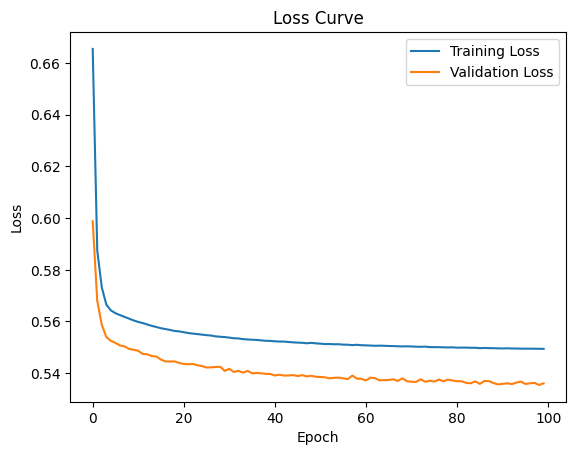

In [178]:
# Visualize the cost function 
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [179]:
y_pred_nn_la = (model.predict(X_la_test) > 0.5).astype(int)
accuracy_nn_la = accuracy_score(y_la_test, y_pred_nn_la)
print("NN Accuracy:", accuracy_nn_la)

396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
NN Accuracy: 0.7599841834717279


In [181]:
(949/1340)*(0.971*80)+(391/1340)*(0.043*(-1))

55.00112462686567